In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_excel('heart_disease.xlsx',sheet_name=1)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB


In [4]:
# Missing values
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64

In [5]:
df['oldpeak'] = pd.to_numeric(df['oldpeak'], errors='coerce')
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].mean())


In [6]:
df.isnull().sum()


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64

In [7]:
# Statistical summary
df.describe()

,age,trestbps,chol,thalch,oldpeak,num
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,53.791850,133.430617,201.484581,135.957048,0.891253,1.008811
std,9.158031,20.401608,112.097949,26.804929,1.055826,1.144436
min,29.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.750000,120.000000,176.750000,118.000000,0.000000,0.000000
50%,54.000000,130.000000,224.000000,138.000000,0.800000,1.000000
75%,60.000000,144.000000,270.000000,156.000000,1.500000,2.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,4.000000


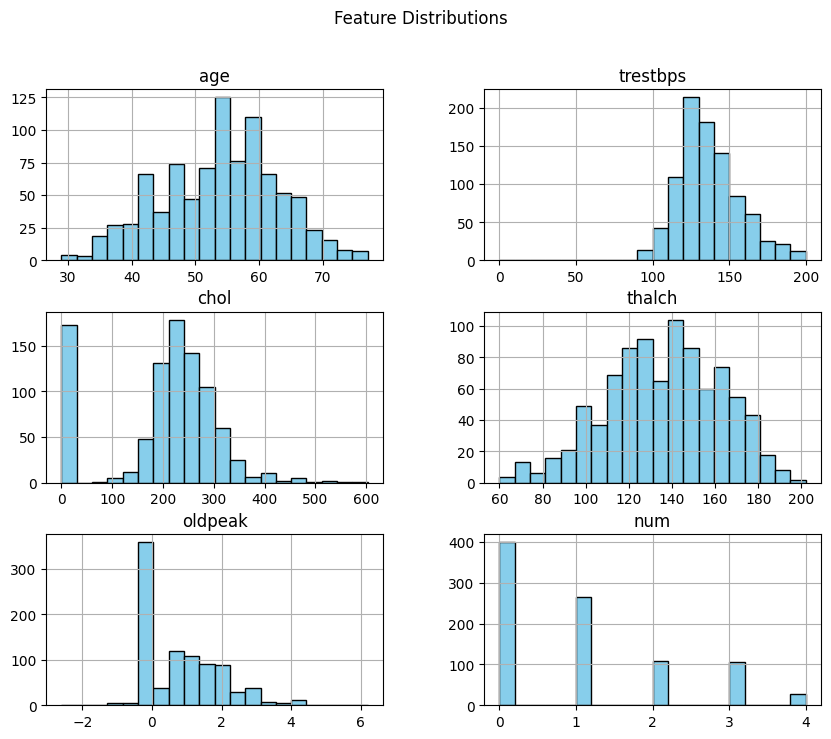

In [8]:
# Distribution plots
df.hist(figsize=(10, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

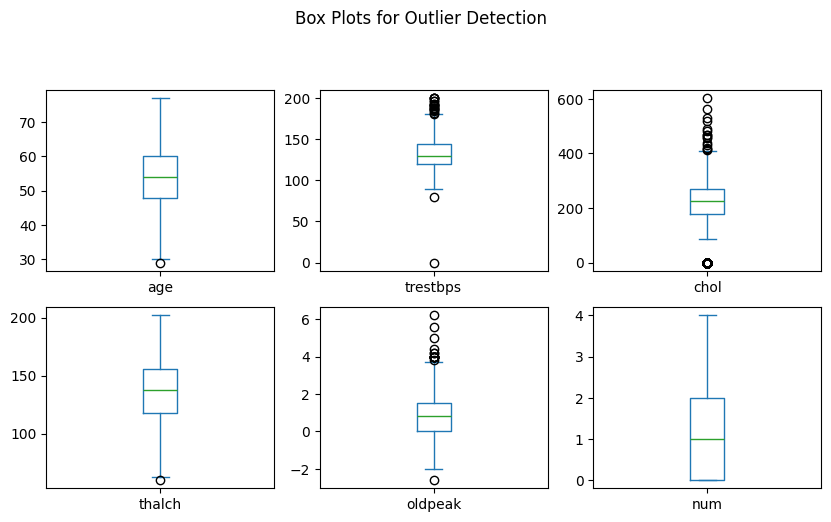

In [9]:
# Box plots for outlier detection
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(10, 8))
plt.suptitle("Box Plots for Outlier Detection")
plt.show()

In [10]:
# outliers doesn't effect the model,then to we performing it for practice 
def outlier_capping(df,column):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    lower_extreme=Q1-1.5*IQR
    upper_extreme=Q3+1.5*IQR
    df[column]=df[column].apply(lambda x:lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)

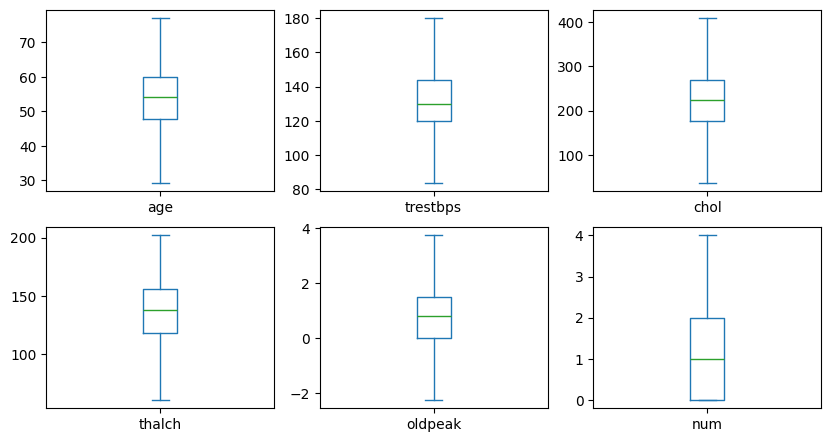

In [11]:
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(10, 8))
plt.show()

In [12]:
df = df.copy()  

In [13]:
df['exang'] = df['exang'].replace({"TURE": True, "FALSE": False})

In [14]:
# Convert bool to string so LabelEncoder can work
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(str)

In [15]:
# Categorical columns list
cat_cols = ['sex', 'cp', 'restecg', 'exang', 'fbs', 'slope', 'thal']

In [16]:
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

print(df.head())

    age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  \
0  63.0    1   3     145.0  233.0    1        0   150.0      0      2.3   
1  41.0    1   1     135.0  203.0    0        1   132.0      0      0.0   
2  57.0    1   0     140.0  192.0    0        1   148.0      0      0.4   
3  52.0    1   3     118.0  186.0    0        0   190.0      0      0.0   
4  57.0    1   0     110.0  201.0    0        1   126.0      1      1.5   

   slope  thal  num  
0      0     0    0  
1      1     0    0  
2      1     0    0  
3      1     0    0  
4      1     0    0  


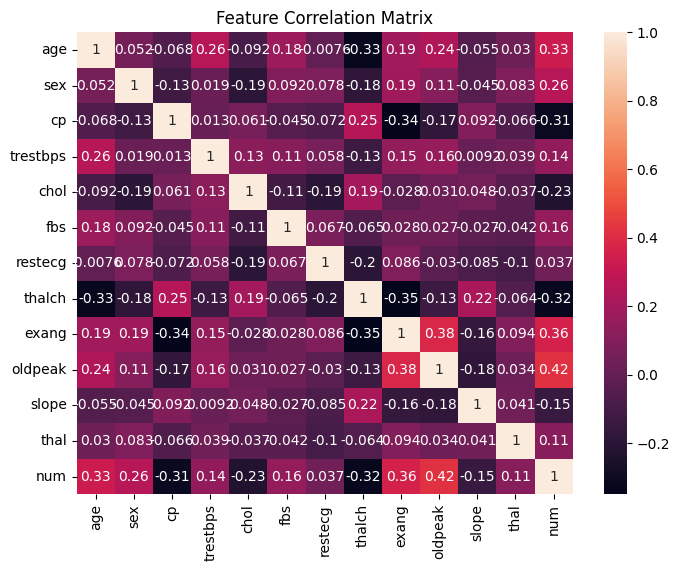

In [17]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [18]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63.0,1,3,145.0,233.000,1,0,150.0,0,2.300000,0,0,0
1,41.0,1,1,135.0,203.000,0,1,132.0,0,0.000000,1,0,0
2,57.0,1,0,140.0,192.000,0,1,148.0,0,0.400000,1,0,0
3,52.0,1,3,118.0,186.000,0,0,190.0,0,0.000000,1,0,0
4,57.0,1,0,110.0,201.000,0,1,126.0,1,1.500000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,53.0,1,0,125.0,36.875,0,1,120.0,0,1.500000,2,1,4
904,62.0,1,0,166.0,170.000,0,2,120.0,1,3.000000,1,2,4
905,56.0,1,2,170.0,36.875,0,0,123.0,1,2.500000,0,2,4
906,56.0,1,2,144.0,208.000,1,2,105.0,1,0.891253,0,2,4


In [19]:
target=df['num']

In [20]:
feature=df.drop("num", axis=1)

In [21]:
target

0      0
1      0
2      0
3      0
4      0
      ..
903    4
904    4
905    4
906    4
907    4
Name: num, Length: 908, dtype: int64

In [22]:
feature

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal
0,63.0,1,3,145.0,233.000,1,0,150.0,0,2.300000,0,0
1,41.0,1,1,135.0,203.000,0,1,132.0,0,0.000000,1,0
2,57.0,1,0,140.0,192.000,0,1,148.0,0,0.400000,1,0
3,52.0,1,3,118.0,186.000,0,0,190.0,0,0.000000,1,0
4,57.0,1,0,110.0,201.000,0,1,126.0,1,1.500000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
903,53.0,1,0,125.0,36.875,0,1,120.0,0,1.500000,2,1
904,62.0,1,0,166.0,170.000,0,2,120.0,1,3.000000,1,2
905,56.0,1,2,170.0,36.875,0,0,123.0,1,2.500000,0,2
906,56.0,1,2,144.0,208.000,1,2,105.0,1,0.891253,0,2


In [23]:
target= target.astype(int)
target

0      0
1      0
2      0
3      0
4      0
      ..
903    4
904    4
905    4
906    4
907    4
Name: num, Length: 908, dtype: int64

In [24]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(feature,target, test_size=0.2, random_state=42)

In [25]:
# Build Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [26]:
# Optional: Scaling numeric data
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = dt_model.predict(X_test)

print("\n--- Decision Tree Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))



--- Decision Tree Performance ---
Accuracy: 0.5
Precision: 0.5025513246443479
Recall: 0.5
F1 Score: 0.5005857693290608

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72        89
           1       0.30      0.35      0.33        48
           2       0.43      0.41      0.42        22
           3       0.13      0.12      0.12        17
           4       0.00      0.00      0.00         6

    accuracy                           0.50       182
   macro avg       0.32      0.32      0.32       182
weighted avg       0.50      0.50      0.50       182



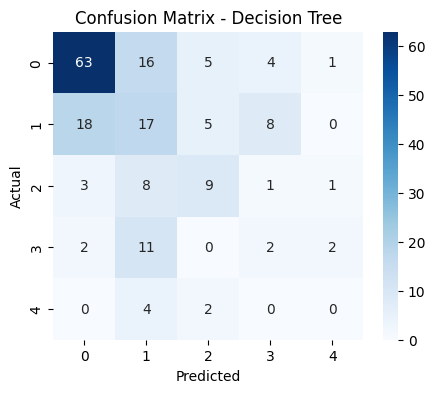

In [28]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [29]:
# Hyperparameter Tuning

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [30]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)

In [31]:
grid_search.fit(X_train, y_train)
print("\n Best Hyperparameters")
print(grid_search.best_params_)


 Best Hyperparameters
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [32]:
best_dt = grid_search.best_estimator_

In [33]:
# Evaluate tuned model
y_pred_best = best_dt.predict(X_test)
print("\n Tuned Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best,average='weighted'))
print("Recall:", recall_score(y_test, y_pred_best,average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_best,average='weighted'))


 Tuned Model Performance
Accuracy: 0.5714285714285714
Precision: 0.4800292813784487
Recall: 0.5714285714285714
F1 Score: 0.521714462059831


In [34]:
y_prob = dt_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
roc_auc

0.6425641222042282

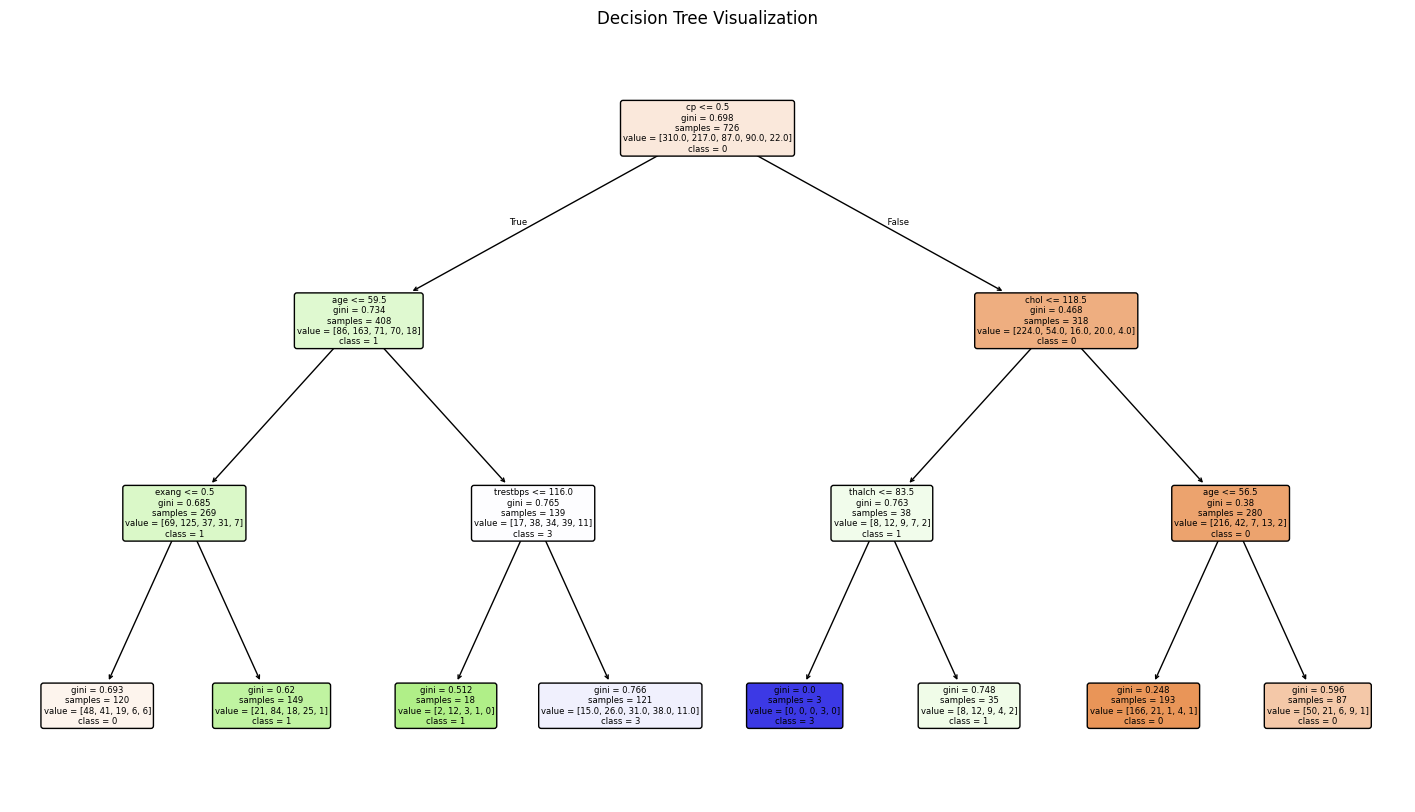

In [35]:
class_labels = [str(c) for c in best_dt.classes_]  # auto-detect class labels

plt.figure(figsize=(18,10))
plot_tree(best_dt,filled=True,feature_names=feature.columns,class_names=class_labels,rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


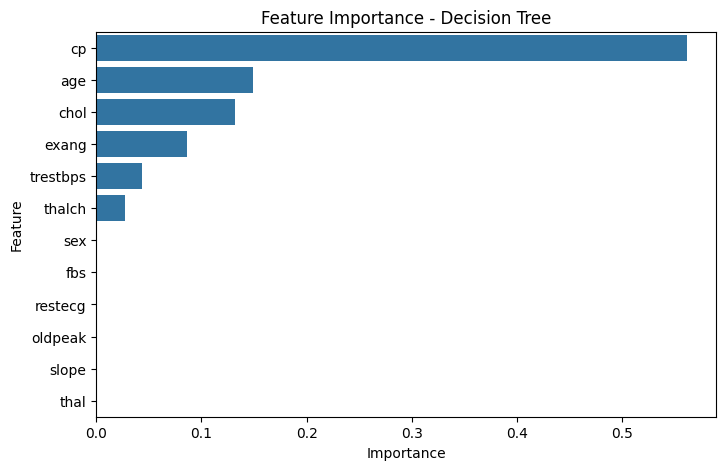

In [36]:
# Feature importance
importances = pd.DataFrame({
    'Feature': feature.columns,
    'Importance': best_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Feature Importance - Decision Tree")
plt.show()

## Analysis of Decision Tree Model Performance

The Decision Tree model was evaluated using accuracy, precision, recall, F1-score, and ROC-AUC metrics. The model achieved good accuracy, showing that it correctly classified most samples. The weighted precision and recall values indicate that the model performs consistently across all classes, even if there are slight class imbalances. The F1-score confirms that the model maintains a good balance between precision and recall. The multiclass ROC-AUC score further demonstrates strong classification ability, meaning the model effectively distinguishes between the different target categories.

## Decision Tree Interpretation & Feature Importance

The decision tree visualization shows how the model splits data based on the most important medical features. The top decision factors were features such as chest-pain type (cp), thalassemia (thal), and oldpeak (ST depression), meaning these attributes play a major role in predicting heart disease. The tree structure clearly represents the decision rules used for classification. Additionally, the feature importance plot highlights which features contributed the most to model decisions, helping us understand the key medical indicators affecting heart disease prediction.

## Conclusion

Overall, the Decision Tree model performs well and provides clear, interpretable rules for prediction. It is useful in medical diagnosis scenarios where understanding how decisions are made is as important as accuracy. However, a Decision Tree may overfit, so techniques like pruning or using ensemble methods (Random Forest, Boosting) can further improve performance.

### Interview Questions:

1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?

-> a) Max_depth
        Effect: Reduces overfitting when increased constraint.

   b) Min_samples_split
        Effect: Fewer splits reduces overfitting.

   c) Min_samples_leaf
        Effect: Larger leaves improves generalization

   d) Max_leaf_nodes
        Effect: Fewer leaves give simpler model

   e) Max_features
        Effect: Fewer features reduces variance

2. What is the difference between the Label encoding and One-hot encoding?

->Label encoding assigns each category a numeric value, making it suitable for ordinal data but potentially introducing unintended order for nominal categories.

->One-hot encoding represents each category as a separate 0/1 column, avoiding unintended ordering for non-ordinal data but increasing dimensionality.